### Checking VIX for past volatilities

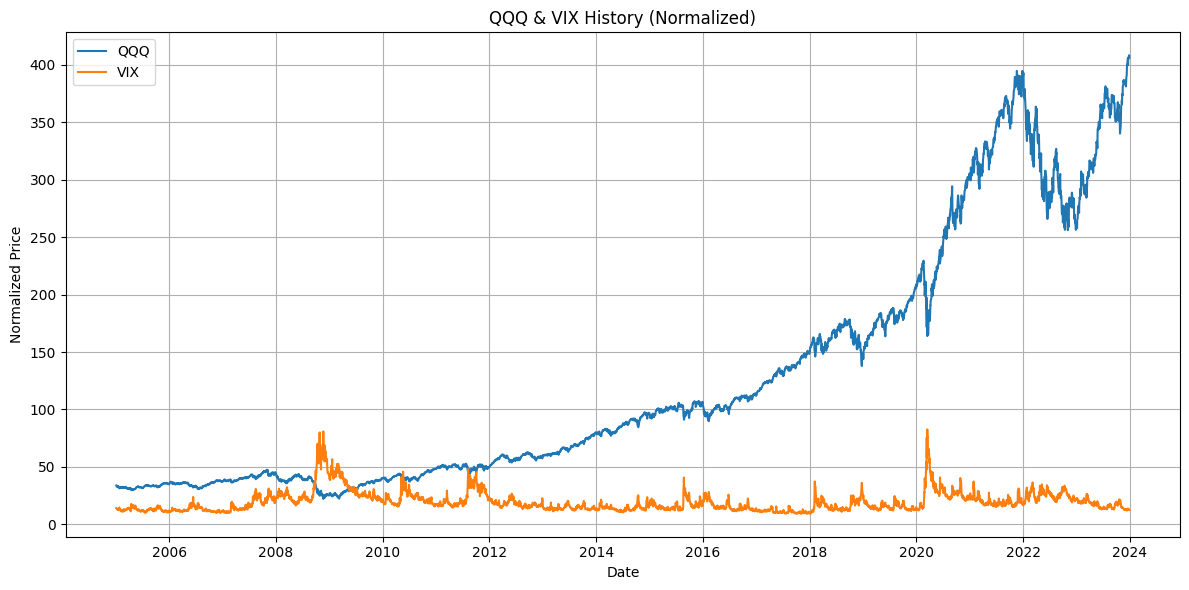

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# Download data
qqq = yf.download("QQQ", start="2005-01-01", end="2023-12-31", progress=False)["Close"]
vix = yf.download("^VIX", start="2005-01-01", end="2023-12-31", progress=False)["Close"]

# Combine into one DataFrame
data = pd.concat([qqq, vix], axis=1)
data.columns = ['QQQ', 'VIX']
data.dropna(inplace=True)
# Normalize for comparison (optional)
#data_normalized = data / data.iloc[0]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(data.index, data["QQQ"], label='QQQ')
plt.plot(data.index, data["VIX"], label='VIX')
plt.title("QQQ & VIX History (Normalized)")
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import scipy.stats

def bs_delta(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    if option_type == 'call':
        return norm.cdf(d1)
    else:
        return norm.cdf(d1) - 1

def bs_gamma(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.pdf(d1) / (S * sigma * np.sqrt(T))

def solve_hedge(delta_p, gamma_p, delta_c, gamma_c, delta_put, gamma_put):
    A = np.array([[delta_c, delta_put],
                  [gamma_c, gamma_put]])
    b = np.array([-delta_p, -gamma_p])
    solution = np.linalg.solve(A, b)
    return solution  # to get how many x and y

results = []

for date in data.index:
    price = data.loc[date, 'QQQ']
    vix_level = data.loc[date, 'VIX']
    sigma = vix_level / 100  # Rough IV estimate

    S = price
    K = price
    T = 30 / 365
    r = 0.01

    # Greeks of options (ATM)
    delta_call = bs_delta(S, K, T, r, sigma, 'call')
    gamma_call = bs_gamma(S, K, T, r, sigma)
    delta_put = bs_delta(S, K, T, r, sigma, 'put')
    gamma_put = bs_gamma(S, K, T, r, sigma)

    # Portfolio: long 1 QQQ, delta = 1, gamma = 0
    delta_p = 1
    gamma_p = 0

    x, y = solve_hedge(delta_p, gamma_p, delta_call, gamma_call, delta_put, gamma_put)

    results.append({
        'Date': date,
        'VIX': vix_level,
        'Call Contracts': x,
        'Put Contracts': y
    })

hedge_df = pd.DataFrame(results).set_index('Date')
hedge_df


,VIX,Call Contracts,Put Contracts
Date,,,
2005-01-03,14.08,-1.0,1.0
2005-01-04,13.98,-1.0,1.0
2005-01-05,14.09,-1.0,1.0
2005-01-06,13.58,-1.0,1.0
2005-01-07,13.49,-1.0,1.0
...,...,...,...
2023-12-22,13.03,-1.0,1.0
2023-12-26,12.99,-1.0,1.0
2023-12-27,12.43,-1.0,1.0


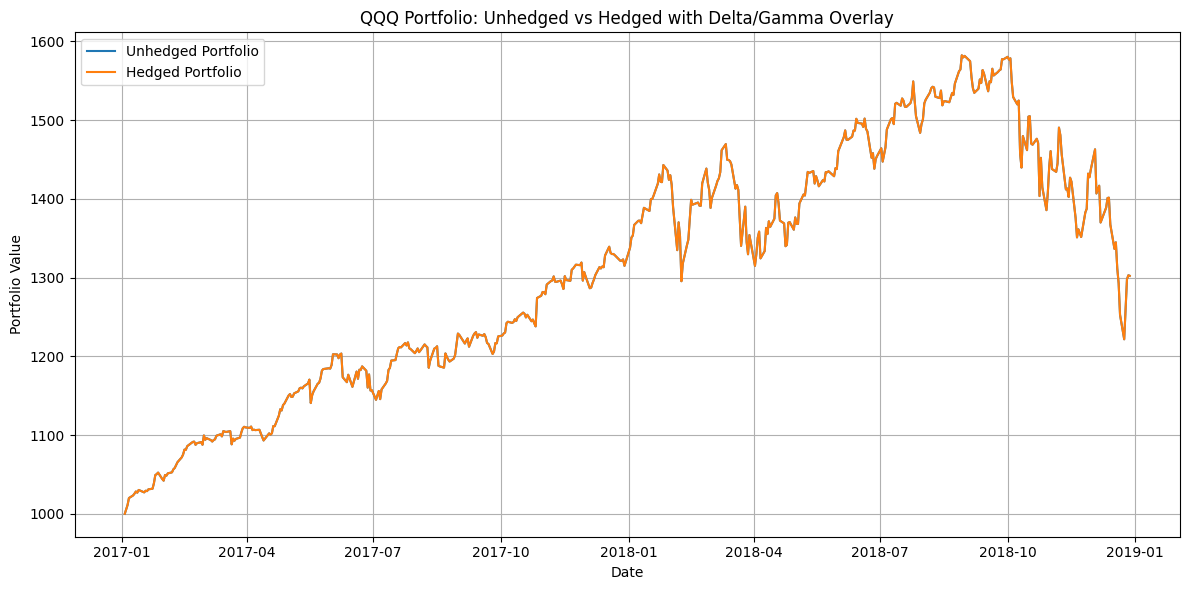

Date
2017-01-03    1000.000000
2017-01-04    1005.437489
2017-01-05    1011.125992
2017-01-06    1019.993272
2017-01-09    1023.339481
                 ...     
2018-12-21    1252.676498
2018-12-24    1221.612820
2018-12-26    1297.888603
2018-12-27    1302.911163
2018-12-28    1302.230480
Name: Hedged, Length: 501, dtype: float64

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# --- Helper functions for Black-Scholes Greeks ---
def bs_delta(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    if option_type == 'call':
        return norm.cdf(d1)
    else:
        return norm.cdf(d1) - 1

def bs_gamma(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.pdf(d1) / (S * sigma * np.sqrt(T))

# --- Download data ---
qqq = yf.download("QQQ", start="2017-01-01", end="2018-12-31", progress=False)["Close"]
vix = yf.download("^VIX", start="2017-01-01", end="2018-12-31", progress=False)["Close"]
data = pd.concat([qqq, vix], axis=1)
data.columns = ['QQQ', 'VIX']
data.dropna(inplace=True)

# --- Simulate Greeks and Hedging ---
results = []

for date, row in data.iterrows():
    S = row["QQQ"]
    sigma = row["VIX"] / 100  # convert VIX to IV
    K = S  # ATM
    T = 30 / 365
    r = 0.01

    # Portfolio (1 QQQ)
    delta_p = 1
    gamma_p = 0

    # Option Greeks
    delta_c = bs_delta(S, K, T, r, sigma, 'call')
    gamma_c = bs_gamma(S, K, T, r, sigma)
    delta_pu = bs_delta(S, K, T, r, sigma, 'put')
    gamma_pu = bs_gamma(S, K, T, r, sigma)

    # Solve hedge weights (x = call, y = put)
    A = np.array([[delta_c, delta_pu], [gamma_c, gamma_pu]])
    b = np.array([-delta_p, -gamma_p])

    try:
        x, y = np.linalg.solve(A, b)
    except np.linalg.LinAlgError:
        x, y = 0, 0

    # Estimate cost: assume option premium ~5% of spot price per contract
    option_cost = 0.05 * S
    hedge_cost = x * option_cost + y * option_cost

    results.append({
        'QQQ': S,
        'VIX': row["VIX"],
        'Delta Call': delta_c,
        'Gamma Call': gamma_c,
        'Delta Put': delta_pu,
        'Gamma Put': gamma_pu,
        'Call Contracts': x,
        'Put Contracts': y,
        'Hedge Cost': hedge_cost
    })

hedge_df = pd.DataFrame(results, index=data.index)

# --- Portfolio Simulation ---
initial_value = 1000
data['Unhedged'] = initial_value * (1 + data['QQQ'].pct_change().fillna(0)).cumprod()
data['Hedge Cost'] = hedge_df['Hedge Cost'].fillna(0).cumsum()
data['Hedged'] = data['Unhedged'] - data['Hedge Cost']

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Unhedged'], label='Unhedged Portfolio')
plt.plot(data.index, data['Hedged'], label='Hedged Portfolio')
plt.title("QQQ Portfolio: Unhedged vs Hedged with Delta/Gamma Overlay")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
qqq = yf.Ticker("QQQ")
qqq.options  # list of expiry dates

chain = qqq.option_chain("2024-04-05")
calls = chain.calls
puts = chain.puts


ValueError: Expiration `2024-04-05` cannot be found. Available expirations are: [2025-03-31, 2025-04-01, 2025-04-02, 2025-04-03, 2025-04-04, 2025-04-11, 2025-04-17, 2025-04-25, 2025-04-30, 2025-05-02, 2025-05-16, 2025-05-30, 2025-06-20, 2025-06-30, 2025-07-31, 2025-08-15, 2025-08-29, 2025-09-19, 2025-09-30, 2025-12-19, 2025-12-31, 2026-01-16, 2026-03-20, 2026-06-18, 2026-09-18, 2026-12-18, 2027-01-15, 2027-06-17, 2027-12-17]

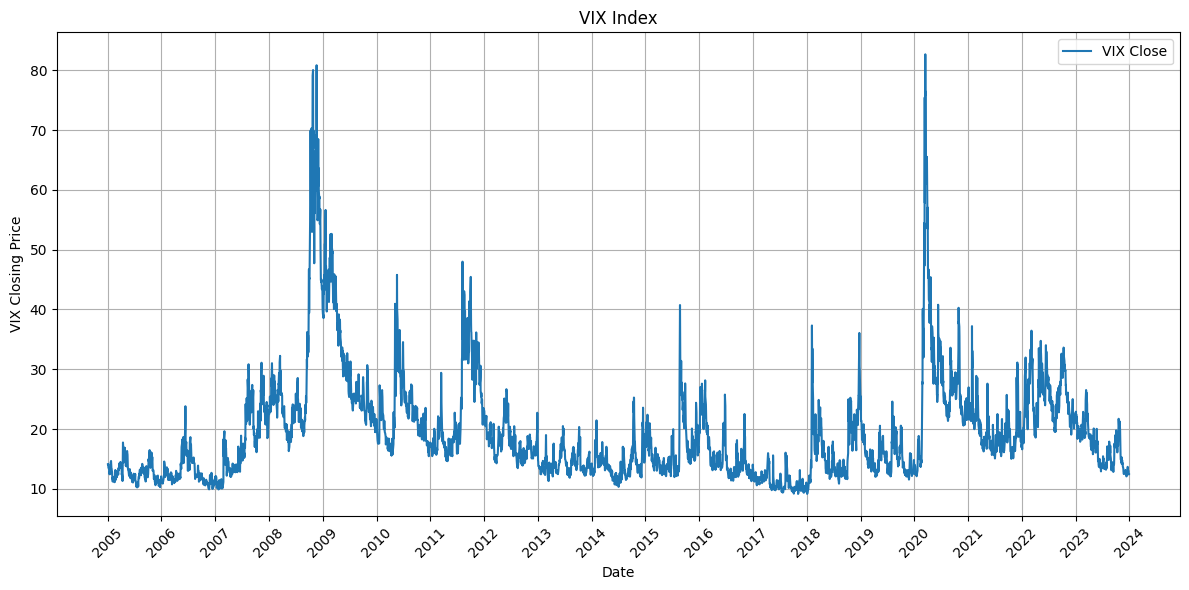

In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Download VIX as a DataFrame (don't select 'Close' immediately)
vix = yf.download("^VIX", start="2005-01-01", end="2023-12-31", progress=False)

# Plot VIX closing prices over time
plt.figure(figsize=(12, 6))
plt.plot(vix.index, vix['Close'], label='VIX Close')
plt.title('VIX Index')
plt.xlabel('Date')
plt.ylabel('VIX Closing Price')
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # one tick per year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.legend()
plt.show()